In [1]:
import os
import time
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import cv2

from src.models import load_model
from src.visualization import get_heatmap, show_mask_on_image, load_and_transform_image_mask
from evaluate_seg import compute_bce_with_logits_mask
from src.transform import image_transform_test, mask_transform


## Warnings
import warnings
warnings.filterwarnings("ignore", message="Clipping input data to the valid range")


c:\Users\rabas\anaconda3\envs\VRP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from hydra import initialize, compose
from omegaconf import OmegaConf
import torch
from src.models import load_model

# 🌀 Setup Hydra manually
with initialize(version_base=None, config_path="config"):
    cfg = compose(config_name="config", overrides=["data=config7", "model=resnet", "model.weight_path=checkpoints/resnet_8_30_7.pth"])

# Tu peux afficher la config complète si besoin :
# print(OmegaConf.to_yaml(cfg))

# 🧠 Charger le modèle une fois
cfg.load_model = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = load_model(cfg.model.name, device, cfg.model).eval()
print(f"✅ Model loaded: {cfg.model.name}")

Loading weights from checkpoints/resnet_8_30_7.pth
✅ Model loaded: resnet


In [3]:

print(f"[Notebook] Model loaded: {cfg.model.name}")

# ── Choose image(s) to visualize ─────────────────────
image_dir = "data/plots/configuration1"
mask_dir = "data/MSH/mask_classic/mask7"
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
modified_dir = "data/plots/configuration7"

[Notebook] Model loaded: resnet



Processing Plot_28.png
(769, 770)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


[timer] Plot_28.png took 0.38


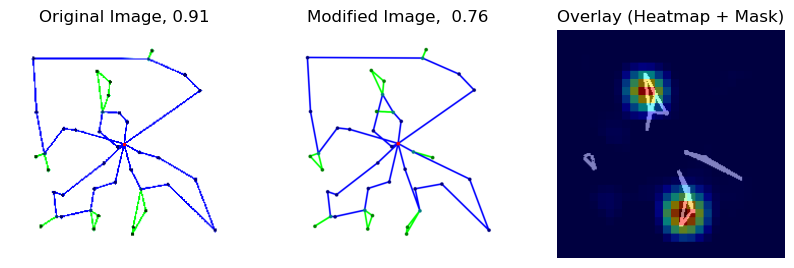

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].



Processing Plot_29.png
(769, 770)
[timer] Plot_29.png took 0.16


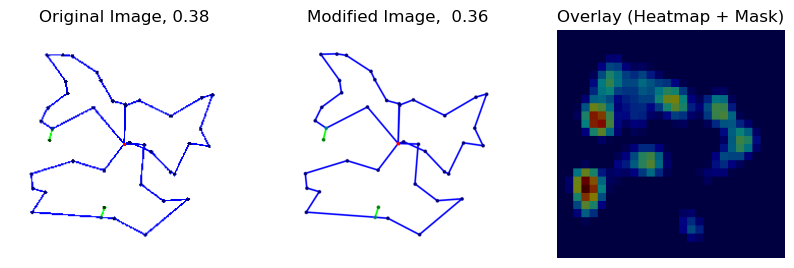


Processing Plot_3.png
(769, 770)
[timer] Plot_3.png took 0.18


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


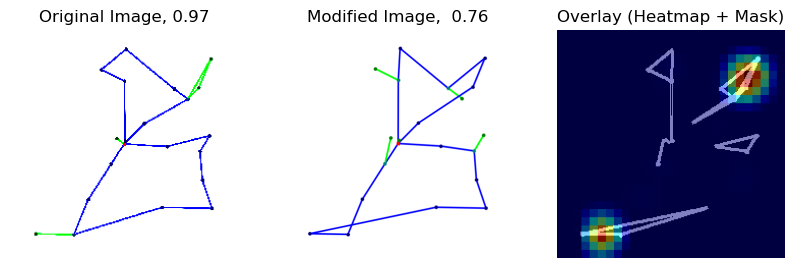


Processing Plot_30.png
(769, 770)
[timer] Plot_30.png took 0.19


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


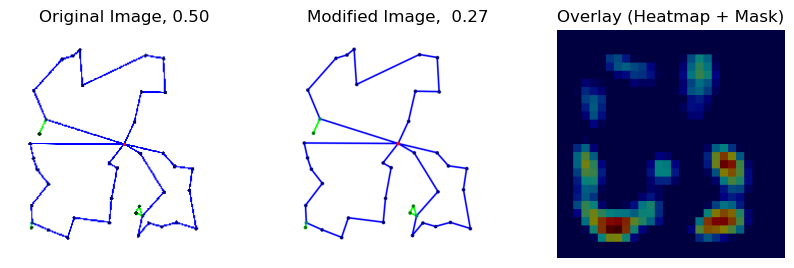


Processing Plot_31.png
(769, 770)
[timer] Plot_31.png took 0.17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


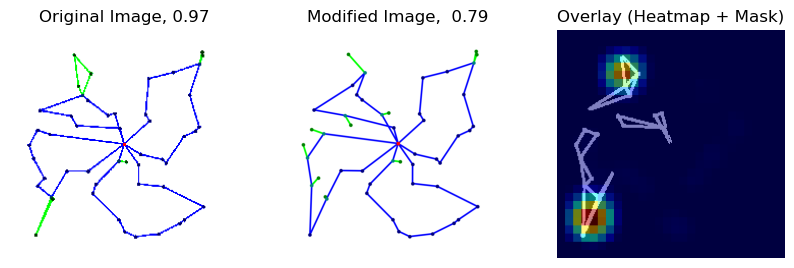

In [6]:
for fname in image_files[20:25]:  # change to [0] or other slice to limit
    print(f"\nProcessing {fname}")
    start = time.perf_counter()

    # Load image and mask
    original_image_path = os.path.join(image_dir, fname)
    mask_path = os.path.join(mask_dir, fname)

    mask = Image.open(mask_path).convert("L")  # Load mask as grayscale
    t_mask = mask_transform()(mask).unsqueeze(0)  # Transform and add batch dimension
    print(mask.size)

    origi_img = Image.open(original_image_path).convert("RGB")
    t_img = image_transform_test()(origi_img).unsqueeze(0)  # Transform and add batch dimension
    t_img = t_img.to(device)  # Move to device

    
    img = Image.open(original_image_path).convert("RGB")

    t_img = image_transform_test(cfg.image_size)(img).unsqueeze(0).to(device)



    modified_image_path = os.path.join(modified_dir, fname)
    modified_img = Image.open(modified_image_path).convert("RGB")

    t_modified_img = image_transform_test(cfg.image_size)(modified_img).unsqueeze(0).to(device)
    
    
    
    # Compute heatmap
    heatmap = get_heatmap(cfg.heatmap.method, model, t_img, cfg.heatmap.args, device=device, percentile_for_thresh = 70)
    prediction = model(t_img.to(device))
    pred_probab = torch.sigmoid(prediction).squeeze().cpu()[1]
    pred_probab_modif = torch.sigmoid(model(t_modified_img.to(device))).squeeze().cpu()[0]

    # Overlay image
    overlay = show_mask_on_image(t_mask, heatmap, alpha=0.5, interpolation=cv2.INTER_NEAREST)

    # Compute loss
    loss = compute_bce_with_logits_mask(heatmap, t_mask)
    print(f"[timer] {fname} took {time.perf_counter() - start:.2f}")
    fig, axs = plt.subplots(1, 3, figsize=(10, 6))
    axs[0].imshow(t_img.squeeze(0).permute(1, 2, 0).cpu().numpy())
    axs[0].set_title("Original Image, {:.2f}".format(pred_probab.item()))
    axs[1].imshow(modified_img)
    axs[1].set_title("Modified Image,  {:.2f}".format(pred_probab_modif.item()))
    axs[2].imshow(overlay)
    axs[2].set_title("Overlay (Heatmap + Mask)")


    for ax in axs:
        ax.axis("off")
    plt.show()